<a href="https://colab.research.google.com/github/TIMEdilation584/JP_Loksatta_moving_hearts/blob/master/20_07_22_kaggle_and_AudioSpectrogramTransfomer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The retrocirce link is great, but needs to be  implemented


In [ ]:
https://github.com/RetroCirce/HTS-Audio-Transformer

In [ ]:
https://www.kaggle.com/code/abhishekprajapat/g2net-audio-spectrogram-transformer/notebook

In [ ]:
!pip install timm==0.4.5

In [ ]:
!git clone https://github.com/YuanGongND/ast.git --quiet
!pip install llvmlite --quiet
!pip install wget --quiet
!pip install zipp --quiet
#!pip install wandb --upgrade --quiet
!pip install nnAudio --quiet
!pip install pytorch_lightning --quiet

In [ ]:
import sys
sys.path.append('./ast/src')

In [ ]:
!pip install albumentations==0.4.6

In [ ]:
!unzip models.zip

In [ ]:
import os
import glob
#import wandb
import shutil

from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import timm
import torch
from models import ASTModel
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader

from nnAudio.Spectrogram import CQT1992v2

from tqdm.notebook import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.7/dist-packages/nnAudio/Spectrogram.py:7: Warning: importing Spectrogram subpackage will be deprecated soon. You should import the feature extractor from the feature subpackage. See actual documentation.
  category=Warning,


Model

In [ ]:
%cd ./ast/

base_model = ASTModel(label_dim=1,
                     fstride=5, tstride=5, \
                     input_fdim=69, input_tdim=193, \
                     imagenet_pretrain=True, audioset_pretrain=False, \
                     model_size='base384')

/content/ast
---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: False


Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_distilled_patch16_384-d0272ac0.pth" to ../../pretrained_models/hub/checkpoints/deit_base_distilled_patch16_384-d0272ac0.pth


frequncey stride=5, time stride=5
number of patches=396


In [ ]:
# ====================================================
class Config:
    debug = False
    num_workers = 4
    epochs = 3
    lr = 1e-4
    weight_decay = 1e-6
    batch_size = 32
    seed = 1234
    target_size = 1
    n_folds = 5
    target_col = 'target'
    LOSS = torch.nn.BCEWithLogitsLoss()
    epochs = 10
    dev_run = False

if Config.debug:
    train = train.sample(n=50000, random_state=Config.seed).reset_index(drop=True)
    Config.epochs = 1
    Config.dev_run = True
    

pl.seed_everything(Config.seed)

Global seed set to 1234


1234

Dataset

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.labels = df[Config.target_col].values
        self.wave_transform = CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=64)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def apply_qtransform(self, waves, transform):
        waves = np.hstack(waves)
        waves = waves / np.max(waves)
        waves = torch.from_numpy(waves).float()
        image = transform(waves)
        return image

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        waves = np.load(file_path)
        image = self.apply_qtransform(waves, self.wave_transform)
        if self.transform:
            image = image.squeeze().numpy()
            image = self.transform(image=image)['image']
        label = torch.tensor(self.labels[idx]).float()
        return image[0], label

Transforms

In [ ]:
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            ToTensorV2(),
        ])

dataloader

In [ ]:



import albumentations 
from albumentations.pytorch import ToTensorV2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torch.utils.data import Dataset

import glob
from tqdm import tqdm

from torch.utils.data import DataLoader


In [ ]:

train_transforms = A.Compose(
    [
        
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
      
        ToTensorV2(),
    ]
)

In [ ]:
####################################################
#       Create Train, Valid and Test sets
####################################################
train_data_path = '/content/drive/MyDrive/Project/AugImgSet_Input/ImgAugMelSpec4DL/train' 
test_data_path = '/content/drive/MyDrive/Project/AugImgSet_Input/ImgAugMelSpec4DL/test/'
val_data_path = '/content/drive/MyDrive/Project/AugImgSet_Input/ImgAugMelSpec4DL/val/'

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

#1.
# get all the paths from train_data_path and append image paths and class to to respective lists
# eg. train path-> 'images/train/26.Pont_du_Gard/4321ee6695c23c7b.jpg'
# eg. class -> 26.Pont_du_Gard
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))
    
train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

#2.
# split train valid from train paths (80,20)
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 

#3.
# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

train_image_path example:  /content/drive/MyDrive/Project/AugImgSet_Input/ImgAugMelSpec4DL/train/Sonar/sonar-1_aug2_melspec_timeMask.jpg
class example:  Tug
Train size: 806
Valid size: 202
Test size: 336


In [ ]:
#######################################################
#      Create dictionary for class indexes
#######################################################

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [ ]:
#######################################################
#               Define Dataset Class
#######################################################

class AudioSpectogramTransformer(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label
    
#######################################################
#                  Create Dataset
#######################################################

train_dataset = AudioSpectogramTransformer(train_image_paths,train_transforms)
valid_dataset = AudioSpectogramTransformer(valid_image_paths,test_transforms) #test transforms are applied
test_dataset = AudioSpectogramTransformer(test_image_paths,test_transforms)

In [ ]:
print('The shape of tensor for 50th image in train dataset: ',train_dataset[49][0].shape)
print('The label for 50th image in train dataset: ',train_dataset[49][1])

The shape of tensor for 50th image in train dataset:  torch.Size([3, 302, 465])
The label for 50th image in train dataset:  4


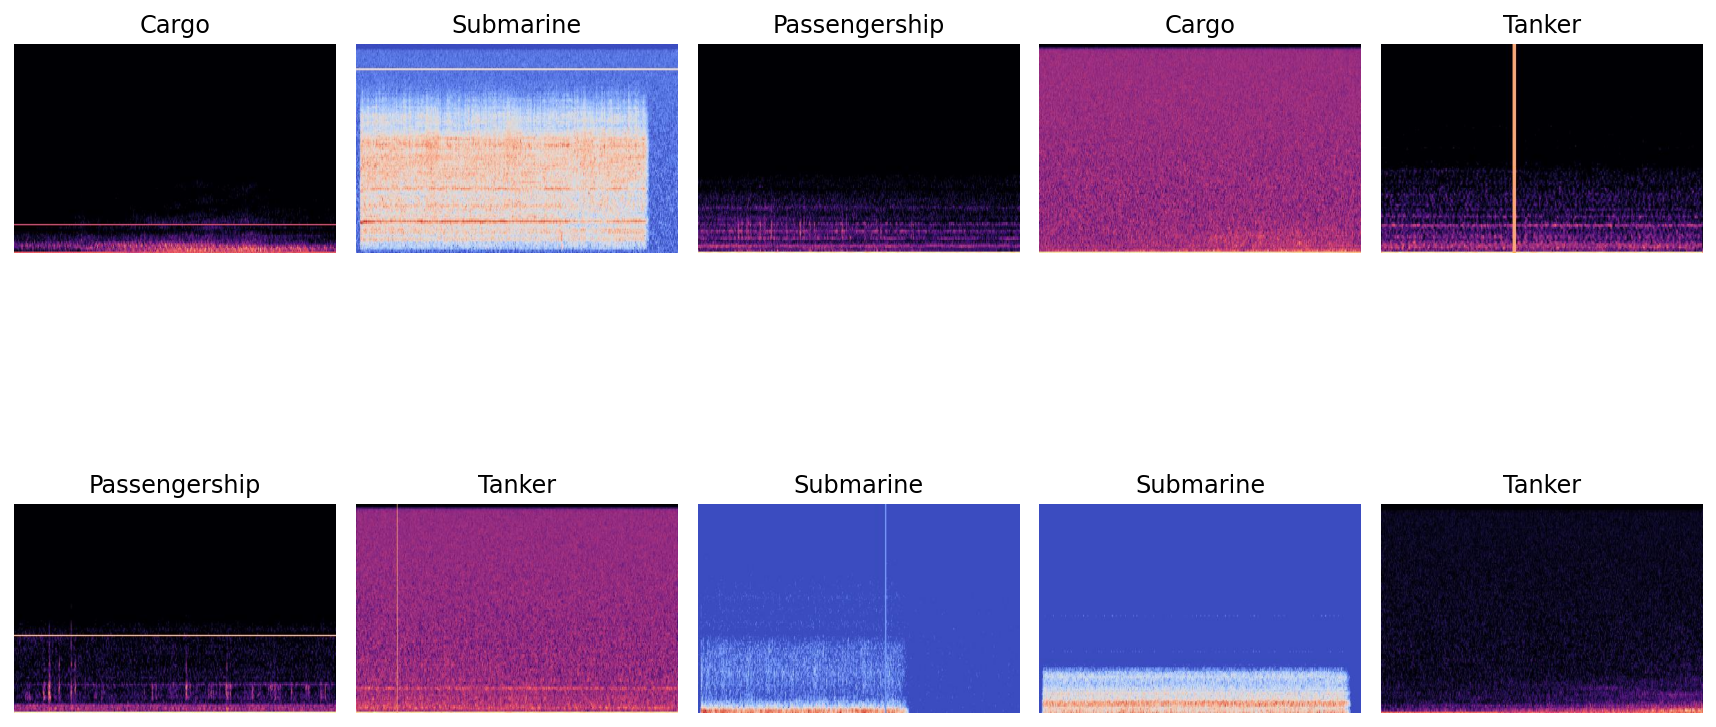

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

#######################################################
#                  Visualize Dataset
#         Images are plotted after augmentation
#######################################################

def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)

In [ ]:
#train = '/content/drive/MyDrive/Project/AugImgSet_Input/ImgAugMelSpec4DL/train'
#train_dataset = TrainDataset(train, transform=get_transforms(data='train'))


train_dl = DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

'''train_dl = DataLoader(train_dataset, 
                      batch_size=Config.batch_size,
                      num_workers=Config.num_workers,
                      shuffle=True,
                      pin_memory=True)
'''

#valid_dataset = TrainDataset(valid, transform=get_transforms(data='valid'))


valid_dl = DataLoader(
    valid_dataset, batch_size=64, shuffle=True
)
'''
valid_dl = DataLoader(valid_dataset,
                     batch_size=Config.batch_size,
                     num_workers=Config.num_workers,
                     pin_memory=True)

                     '''



'\nvalid_dl = DataLoader(valid_dataset,\n                     batch_size=Config.batch_size,\n                     num_workers=Config.num_workers,\n                     pin_memory=True)\n\n                     '

In [ ]:
sample = None
for i in train_dl:
    print(i[0].shape, i[1])
    sample = i[0]
    break


torch.Size([64, 3, 302, 465]) tensor([6, 1, 4, 7, 1, 3, 6, 4, 6, 3, 3, 4, 2, 2, 4, 7, 5, 6, 6, 1, 6, 4, 6, 3,
        3, 3, 4, 2, 2, 4, 4, 4, 1, 4, 4, 6, 4, 3, 1, 6, 1, 4, 4, 3, 4, 7, 4, 6,
        6, 6, 3, 4, 5, 7, 6, 5, 1, 4, 3, 4, 6, 1, 6, 6])


In [ ]:
class Classifier(pl.LightningModule):
    
    def __init__(self):
        super(Classifier, self).__init__()
        self.model = base_model
        
    def forward(self, x):
        output = self.model(x)
        return output
    
    def training_step(self, batch, batch_no):
        images, labels = batch
        outputs = self(images)
        loss = Config.LOSS(outputs.view(-1), labels)
        return loss
    
    def validation_step(self, batch, batch_no):
        images, labels = batch
        outputs = self(images)
        loss = Config.LOSS(outputs.view(-1), labels)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=Config.lr, 
                                     weight_decay=Config.weight_decay)
        return optimizer

In [ ]:
model = Classifier()

In [ ]:
trainer = pl.Trainer(gpus=1, max_epochs=Config.epochs, fast_dev_run=Config.dev_run)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_dl, valid_dl)